In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from geopy.distance import great_circle
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm_base, tqdm_notebook as tqdm

tqdm_base.pandas()

# installing geopandas on mac with conda is a pain, i recommend starting with a fresh conda env and...
# pip install geopandas numpy pandas shapely fiona six pyproj tables matplotlib tqdm

## Load King County GTFS data from Jan 2018 and find `route_id`'s for the D Line and E Line

In [2]:
# because jan 18 is split across 2 gtfs feeds (https://transitfeeds.com/p/king-county-metro/)
# let's verify that route_id for D and E are consistent
# i downloaded/unzipped gtfs into ./data/source/gtfs_YYYYMMDD dirs
#routes_1 = pd.read_csv('./data/source/gtfs_20171116/routes.txt')
routes_2 = pd.read_csv('./data/source/gtfs_20180118/routes.txt')

In [3]:
#routes_1[(routes_1.route_short_name == 'D Line') | (routes_1.route_short_name == 'E Line')]

In [4]:
routes_2[(routes_2.route_short_name == 'D Line') | (routes_2.route_short_name == 'E Line')]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
202,102581,KCM,D Line,NaN,Blue Ridge/Crown Hill - Ballard - Downtown Sea...,3,http://metro.kingcounty.gov/schedules/674/n0.html,NaN,NaN
205,102615,KCM,E Line,NaN,Aurora Village Transit Center - Downtown Seattle,3,http://metro.kingcounty.gov/schedules/675/n0.html,NaN,NaN


In [5]:
# route_id is unchanged
# D line = 102581
# E line = 102615

## Load the realtime location data and get the locations for the D Line

In [6]:
locations_df = pd.read_hdf('./data/intermed/positions_201801.h5', key='df')

In [7]:
# D Line
locations_df[locations_df.route_id == 102581].shape

(167619, 8)

In [8]:
#E Line
locations_df[locations_df.route_id == 102615].shape

(197432, 8)

In [9]:
# For the D, focus on this segment:
# 1). Pine to 1st N/Key Arena

In [10]:
dline_df = locations_df[locations_df.route_id == 102581]

In [11]:
dline_df.head()

,route_id,timestamp,trip_id,vehicle_id,vehicle_lat,vehicle_long,time_utc,time_pct
timestamp_utc,,,,,,,,
2017-12-31 23:58:01,102581,1514764681,34921951,6069,47.702541,-122.363777,2017-12-31 23:58:01,2017-12-31 15:58:01-08:00
2017-12-31 23:58:21,102581,1514764701,34921948,6065,47.613445,-122.342667,2017-12-31 23:58:21,2017-12-31 15:58:21-08:00
2017-12-31 23:58:45,102581,1514764725,34921896,6093,47.649120,-122.376137,2017-12-31 23:58:45,2017-12-31 15:58:45-08:00
2017-12-31 23:59:07,102581,1514764747,34921897,6203,47.620068,-122.355438,2017-12-31 23:59:07,2017-12-31 15:59:07-08:00
2017-12-31 23:59:24,102581,1514764764,34921950,6205,47.680241,-122.376770,2017-12-31 23:59:24,2017-12-31 15:59:24-08:00


## Load trip data and shape data

### Use `trips_df` to determine `shape_id` for northbound D Line, and extract the shape from `shapes_df`

In [12]:
trips_df = pd.read_csv('./data/source/gtfs_20180118/trips.txt')
shapes_df = pd.read_csv('./data/source/gtfs_20180118/shapes.txt')

In [13]:
# It appears that direction_id = 0 for the D is northbound because trip_headsign = "Ballard Uptown" 
# vs. trip_headsign = "Downtown Seattle Uptown" when direction_id = 1.
trips_df[(trips_df.route_id == 102581) & (trips_df.direction_id == 0)].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12146,102581,66726,34815377,Ballard Uptown,LOCAL,0,4759512,11674003,0,101.0
12147,102581,66726,34815378,Ballard Uptown,LOCAL,0,4759514,11674003,0,101.0
12148,102581,66726,34815379,Ballard Uptown,LOCAL,0,4759517,11674003,0,101.0
12149,102581,66726,34815380,Ballard Uptown,LOCAL,0,4759510,11674003,1,110.0
12150,102581,66726,34815381,Ballard Uptown,LOCAL,0,4759516,11674003,1,110.0


In [14]:
#Get shape for northbound D Line.
#Make a copy to avoid the warning "A value is trying to be set on a copy of a slice from a DataFrame"
#when we add a column later.
d_shape = shapes_df[shapes_df.shape_id == 11674003].copy()

In [15]:
d_shape.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
112745,11674003,47.601669,-122.330170,1,0.0
112746,11674003,47.601719,-122.330269,2,30.0
112747,11674003,47.601761,-122.330391,3,64.5
112748,11674003,47.601830,-122.330498,4,100.1
112749,11674003,47.601936,-122.330650,5,153.5


In [16]:
#list(zip(d_shape.shape_pt_lon, d_shape.shape_pt_lat))

In [17]:
d_shape['coordinates'] = list(zip(d_shape.shape_pt_lon, d_shape.shape_pt_lat))
d_shape['coordinates'] = d_shape['coordinates'].apply(Point)

In [18]:
d_shape

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
112745,11674003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
112746,11674003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
112747,11674003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
112748,11674003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
112749,11674003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)
112750,11674003,47.602058,-122.330757,6,205.6,POINT (-122.330757 47.6020584)
112751,11674003,47.602085,-122.330788,7,217.6,POINT (-122.330788 47.6020851)
112752,11674003,47.602764,-122.331413,8,511.7,POINT (-122.331413 47.6027641)
112753,11674003,47.603481,-122.332069,9,818.2,POINT (-122.332069 47.6034813)
112754,11674003,47.604153,-122.332672,10,1104.1,POINT (-122.332672 47.6041527)


## Create a GeoDataFrame from `d_shape` DataFrame, and display the shape

In [19]:
gdf = gpd.GeoDataFrame(d_shape, geometry='coordinates')

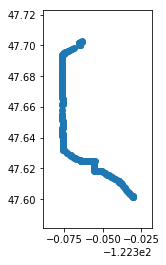

In [20]:
gdf.plot()
plt.show()

In [21]:
gdf.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coordinates
112745,11674003,47.601669,-122.330170,1,0.0,POINT (-122.33017 47.6016693)
112746,11674003,47.601719,-122.330269,2,30.0,POINT (-122.330269 47.6017189)
112747,11674003,47.601761,-122.330391,3,64.5,POINT (-122.330391 47.6017609)
112748,11674003,47.601830,-122.330498,4,100.1,POINT (-122.330498 47.6018295)
112749,11674003,47.601936,-122.330650,5,153.5,POINT (-122.33065 47.6019363)


## Load the stops data so we can later find the closest stop to each bus location

In [22]:
stops_df = pd.read_csv('./data/source/gtfs_20180118/stops.txt')

In [23]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone
0,1000,NaN,Pine St & 9th Ave,NaN,47.613415,-122.332138,21,NaN,0,NaN,America/Los_Angeles
1,10000,NaN,NE 55th St & 43rd Ave NE,NaN,47.668575,-122.283653,1,NaN,0,NaN,America/Los_Angeles
2,10005,NaN,40th Ave NE & NE 51st St,NaN,47.665886,-122.284897,1,NaN,0,NaN,America/Los_Angeles
3,10010,NaN,NE 55th St & 39th Ave NE,NaN,47.668579,-122.285667,1,NaN,0,NaN,America/Los_Angeles
4,10020,NaN,NE 55th St & 37th Ave NE,NaN,47.668579,-122.288300,1,NaN,0,NaN,America/Los_Angeles


## Use first `trip_id` from `dline_df` to see the route number for the northbound D Line

`route_id` = 102581 for the D Line northbound

In [24]:
trips_df[trips_df.trip_id == 34921951]

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
21347,102581,21439,34921951,Downtown Seattle Uptown,LOCAL,1,4764891,20674043,0,101.0


## NEXT: To get stops for a route: route -> trips -> stop_times -> stops

### Get all the D Line northbound trips (`route_id` = 102581) from the `trips_df`

Filter by `direction_id == 0` to make sure they're northbound.

In [26]:
d_trips = trips_df[trips_df.route_id == 102581]

In [27]:
d_trips[d_trips.direction_id == 0].head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id
12146,102581,66726,34815377,Ballard Uptown,LOCAL,0,4759512,11674003,0,101.0
12147,102581,66726,34815378,Ballard Uptown,LOCAL,0,4759514,11674003,0,101.0
12148,102581,66726,34815379,Ballard Uptown,LOCAL,0,4759517,11674003,0,101.0
12149,102581,66726,34815380,Ballard Uptown,LOCAL,0,4759510,11674003,1,110.0
12150,102581,66726,34815381,Ballard Uptown,LOCAL,0,4759516,11674003,1,110.0


### Load `stop_times.txt` into `stop_times_df` 

### Find all D Line northbound `trip_id`'s from the `d_trips` dataframe and store in `d_northbound_trip_ids` Series

### Use these `trip_id`'s to find all `stop_id`s for D Line northbound stops from  `stop_times_df`

### Store the unique `stop_id`'s in a numpy array `d_north_stop_ids`

In [28]:
stop_times_df = pd.read_csv('./data/source/gtfs_20180118/stop_times.txt')

In [29]:
d_northbound_trip_ids = d_trips.loc[d_trips.direction_id == 0,'trip_id']

In [30]:
d_northbound_stop_times = stop_times_df[stop_times_df['trip_id'].isin(d_northbound_trip_ids)]

In [31]:
d_north_stop_ids = d_northbound_stop_times['stop_id'].unique()
d_north_stop_ids

array([ 1610,   538,   558,   578,   600,   605,  1690,  2332,  2360,
        2370, 14038, 14070, 14090, 14110, 14130, 14150, 14170, 14190,
       14200, 14230, 14250, 14280, 14300, 14322, 14340, 14360, 40050,
       28680])

### Get all the D Line northbound stops from `stops_df` using `d_north_stop_ids`

### Create a dataframe `d_north_stops` indexed by the `stop_id`'s with a single column containing the coordinates of each stop as a shapely `Point`

In [32]:
d_north_stops = stops_df[stops_df.stop_id.isin(d_north_stop_ids)]
d_north_stops = d_north_stops.loc[:, ['stop_id', 'stop_lat', 'stop_lon']]
d_north_stops.set_index('stop_id', inplace=True)
d_north_stops['coordinates'] = list(zip(d_north_stops.stop_lon, d_north_stops.stop_lat))
d_north_stops['coordinates'] = d_north_stops['coordinates'].apply(Point)
d_north_stops = d_north_stops.loc[:, ['coordinates']]

In [33]:
d_north_stops.head()

,coordinates
stop_id,
14038,POINT (-122.361153 47.6246681)
14070,POINT (-122.371124 47.628788)
14090,POINT (-122.375481 47.6322517)
14110,POINT (-122.376099 47.63696289999999)
14130,POINT (-122.376114 47.64092249999999)


## Get all locations for D Line northbound trips

In [34]:
d_northbound_trip_ids.head()

12146    34815377
12147    34815378
12148    34815379
12149    34815380
12150    34815381
Name: trip_id, dtype: int64

In [35]:
d_northbound_locations = locations_df[locations_df.trip_id.isin(d_northbound_trip_ids)]
d_northbound_locations = d_northbound_locations[['route_id', 'trip_id', 'vehicle_id', 'vehicle_lat', 'vehicle_long']]

In [36]:
d_northbound_locations.shape

(77723, 5)

In [37]:
dline_df.shape

(167619, 8)

In [38]:
# that's good, our northbound D locations is approx 50% of previously calculated all D locations size

In [39]:
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long
timestamp_utc,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415


## Now we need to find `closest_stop_id` from `d_north_stops` for all `d_northbound_locations`

Write a function to find the closest stop to a `Point` using shapely's `nearest_points` function. Apply the function to the coordinates in `d_northbound_locations` to get the closest stop to each bus location.

In [41]:
d_north_stops.head()

,coordinates
stop_id,
14038,POINT (-122.361153 47.6246681)
14070,POINT (-122.371124 47.628788)
14090,POINT (-122.375481 47.6322517)
14110,POINT (-122.376099 47.63696289999999)
14130,POINT (-122.376114 47.64092249999999)


In [42]:
crs = {'init': 'epsg:4326'}
d_north_stops_gdf = gpd.GeoDataFrame(d_north_stops, crs=crs).set_geometry('coordinates')

def find_closest_stop_id(pnt):
    nearest = nearest_points(d_north_stops_gdf.geometry.unary_union, pnt)
    closest_coords = nearest[0]
    closest_stop = d_north_stops_gdf[d_north_stops_gdf['coordinates'] == closest_coords]
    return closest_stop.index[0]

In [43]:
# Check that the closest stop to the coordinates of the stop is the stop itself 
# pnt = Point(-122.344574, 47.694817)
pnt = Point(-122.361153, 47.6246681)
find_closest_stop_id(pnt)

14038

In [44]:
d_northbound_locations['coordinates'] = d_northbound_locations.apply(lambda x: Point(x['vehicle_long'], x['vehicle_lat']), axis=1)

In [45]:
# output cleared as tqdm generated 1000s of lines
d_northbound_locations['closest_stop_id'] = d_northbound_locations.progress_apply(lambda x: find_closest_stop_id(x['coordinates']), axis=1)

100%|██████████| 77723/77723 [01:40<00:00, 777.07it/s]


In [46]:
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates,closest_stop_id
timestamp_utc,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360


## Join the locations dataframe with the `d_north_stops` dataframe to get the coordinates of the closest stop

In [47]:
d_northbound_locations = d_northbound_locations.merge(d_north_stops,
                                                      how='left',
                                                      left_on='closest_stop_id', 
                                                      right_index=True, 
                                                      suffixes=('_vehicle', '_stop')
                                                     )
d_northbound_locations.head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop
timestamp_utc,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974)
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001)
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001)
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369)
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188)


## Compute the distance from the bus to the closest stop

We use the `geopy.distance` function `great_circle` to compute the distance between two points on Earth given their lattitude and longitude.

The `geopy.distance` function `geodesic` is more accurate (uses an ellipsoid model of the Earth rather than a sphere), but it gives similar answers and takes 10 times as long to run.

For comparison, we also try the simple approximation of the distance using the Pythagorean theorem (i.e. assuming flat Euclidean geometry rather than spherical). For some reason, the difference seems to greater when the points are closer together, which is the opposite of what I would expect...

In [48]:
#Write a function to compute the distance between two geographical points using geopy
def meters_between_points(point1, point2):
    #geopy needs the coordinates in (lat, long), whereas the Points are stored (long, lat)
    return great_circle((point1.y, point1.x), (point2.y, point2.x)).meters

In [49]:
#From timestamp 2017-12-31 23:58:45
bus_coordinates = Point(-122.3761367797852, 47.64912033081055)
stop_coordinates = Point(-122.376045, 47.6490974)
meters_between_points(bus_coordinates, stop_coordinates)

7.33270147592989

In [53]:
#Compare with Euclidean approximation - 10.5 meters vs. 7.3 meters
EARTH_RADIUS_METERS = 6371.009 * 1000
degree_dist = bus_coordinates.distance(stop_coordinates)
np.radians(degree_dist) * EARTH_RADIUS_METERS

10.519167197649717

In [54]:
#From timestamp 2018-01-01 00:00:25
bus_coordinates = Point(-122.376220703125, 47.65950775146485)
stop_coordinates = Point(-122.375977, 47.6634369)
meters_between_points(bus_coordinates, stop_coordinates)

437.28304660827376

In [55]:
#Compare with Euclidean approximation - 437.74 meters meters vs. 437.28 meters
degree_dist = bus_coordinates.distance(stop_coordinates)
np.radians(degree_dist) * EARTH_RADIUS_METERS

437.74158066126256

In [56]:
#Compute the distance from the bus to the closest stop using geopy.distance.great_circle
d_northbound_locations['meters_to_stop'] = (
    d_northbound_locations.progress_apply(lambda df:
                                 meters_between_points(df['coordinates_vehicle'], df['coordinates_stop']),
                                 axis=1
                                )
)
d_northbound_locations.head()

100%|██████████| 77723/77723 [00:07<00:00, 10552.31it/s]


,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop
timestamp_utc,,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974),7.332701
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001),6.837902
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001),7.454585
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369),437.283047
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188),7.445441


In [57]:
#Compute the Euclidean approximation of the distance from the bus to the closest stop for comparison

#If we import geopy, we could instead use geopy.EARTH_RADIUS * 1000
EARTH_RADIUS_METERS = 6371.009 * 1000

d_northbound_locations['euclid_meters_to_stop'] = (
    d_northbound_locations.progress_apply(lambda df: EARTH_RADIUS_METERS *
                                 np.radians(df['coordinates_vehicle'].distance(df['coordinates_stop'])),
                                 axis=1
                                )
)
d_northbound_locations.head()

100%|██████████| 77723/77723 [00:02<00:00, 26135.52it/s]


,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop,euclid_meters_to_stop
timestamp_utc,,,,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,POINT (-122.3761367797852 47.64912033081055),14170,POINT (-122.376045 47.6490974),7.332701,10.519167
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,POINT (-122.3554382324219 47.62006759643555),2332,POINT (-122.355347 47.62006760000001),6.837902,10.144597
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,POINT (-122.3554382324219 47.62009429931641),2332,POINT (-122.355347 47.62006760000001),7.454585,10.570090
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,POINT (-122.376220703125 47.65950775146485),14200,POINT (-122.375977 47.6634369),437.283047,437.741581
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,POINT (-122.3554153442383 47.62318801879883),2360,POINT (-122.355316 47.623188),7.445441,11.046591


## Compare the great circle distances to the Euclidean approximations

Some are very close, and some are several hundered meters off.

In [66]:
#See how different the Euclidean approximation is from the geopy distances -- some are quite close
np.sort(np.abs(d_northbound_locations.meters_to_stop - d_northbound_locations.euclid_meters_to_stop))[:50]

array([4.37657377e-09, 4.37657377e-09, 4.37657377e-09, 4.37657377e-09,
       4.57151828e-09, 4.57151828e-09, 4.67949235e-09, 4.67949235e-09,
       1.64609179e-06, 1.64609179e-06, 1.64609179e-06, 2.12456445e-06,
       2.12456445e-06, 2.12456445e-06, 2.12456445e-06, 2.12456445e-06,
       2.12456445e-06, 2.12456445e-06, 2.12456445e-06, 2.12456445e-06,
       2.12456445e-06, 8.70860452e-06, 1.58861722e-05, 1.58861722e-05,
       1.96389579e-05, 1.96389579e-05, 1.96389579e-05, 2.12601811e-05,
       2.86255826e-05, 2.86255826e-05, 3.21540971e-05, 5.44806464e-05,
       5.44806464e-05, 5.44806464e-05, 5.44806464e-05, 5.44806464e-05,
       5.44806464e-05, 5.44806464e-05, 5.44806464e-05, 5.44806464e-05,
       5.44806464e-05, 5.44806464e-05, 5.44806464e-05, 5.44806464e-05,
       5.44806464e-05, 5.44806464e-05, 5.44806464e-05, 5.44806464e-05,
       5.44806464e-05, 5.44806464e-05])

In [63]:
#See how different the Euclidean approximation is from the geopy distances -- some are quite far apart
np.sort(np.abs(d_northbound_locations.meters_to_stop - d_northbound_locations.euclid_meters_to_stop))[:-50:-1]

array([571.76965829, 184.59871401, 184.59871401, 183.82302524,
       183.64980636, 183.4379708 , 182.93812551, 182.18143807,
       182.18143807, 181.93896586, 181.93896586, 181.93896586,
       181.75199054, 181.40970256, 181.40970256, 181.40970256,
       180.88043933, 180.15287129, 180.15287129, 180.09140111,
       179.38103293, 179.37971975, 179.37971975, 178.84124885,
       178.84124885, 178.60916772, 178.60916772, 177.63851122,
       177.24467507, 177.24467507, 176.86651046, 176.77022058,
       176.29576603, 175.36604511, 175.10962947, 174.83676791,
       174.63517476, 174.22474125, 174.22474125, 174.06462131,
       173.82172443, 173.82172443, 173.09286699, 172.97458293,
       172.97458293, 172.97458293, 172.73735548, 172.56358036,
       172.56358036])

### Sort the whole locations DataFrame to see if we can find any patterns in the differences between the distances

Only a few `stop_id`'s are showing up for the very close points, and a few different `stop_id`'s are showing up for the very far points. Interesting.

In [70]:
#Let's see the actual points
d_northbound_locations['dist_difference'] = np.abs(
    d_northbound_locations.meters_to_stop - d_northbound_locations.euclid_meters_to_stop)
d_northbound_locations_sorted = d_northbound_locations.sort_values(by='dist_difference', axis=0)
d_northbound_locations_sorted.head(10) #Least different

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop,euclid_meters_to_stop,dist_difference
timestamp_utc,,,,,,,,,,,
2018-01-13 22:36:18,102581,34930819,6217,47.692738,-122.376709,POINT (-122.376708984375 47.6927375793457),14360,POINT (-122.376709 47.6911774),173.484273,173.484273,4.376574e-09
2018-01-24 02:34:07,102581,35107073,6087,47.692738,-122.376709,POINT (-122.376708984375 47.6927375793457),14360,POINT (-122.376709 47.6911774),173.484273,173.484273,4.376574e-09
2018-01-14 21:22:22,102581,34921885,6061,47.692738,-122.376709,POINT (-122.376708984375 47.6927375793457),14360,POINT (-122.376709 47.6911774),173.484273,173.484273,4.376574e-09
2018-01-16 15:47:36,102581,35107256,6117,47.692738,-122.376709,POINT (-122.376708984375 47.6927375793457),14360,POINT (-122.376709 47.6911774),173.484273,173.484273,4.376574e-09
2018-01-23 23:57:28,102581,35107200,6082,47.692726,-122.376709,POINT (-122.376708984375 47.69272613525391),14360,POINT (-122.376709 47.6911774),172.211746,172.211746,4.571518e-09
2018-01-20 01:45:03,102581,35107069,6077,47.692726,-122.376709,POINT (-122.376708984375 47.69272613525391),14360,POINT (-122.376709 47.6911774),172.211746,172.211746,4.571518e-09
2018-01-26 00:42:14,102581,35107063,6046,47.692745,-122.376709,POINT (-122.376708984375 47.69274520874024),14360,POINT (-122.376709 47.6911774),174.332624,174.332624,4.679492e-09
2018-01-13 14:29:15,102581,34930958,6086,47.692745,-122.376709,POINT (-122.376708984375 47.69274520874024),14360,POINT (-122.376709 47.6911774),174.332624,174.332624,4.679492e-09
2018-01-20 18:42:31,102581,34930924,6063,47.676247,-122.376671,POINT (-122.3766708374023 47.67624664306641),14280,POINT (-122.376671 47.6767349),54.291772,54.291774,1.646092e-06


In [74]:
# Hmm, it seems to be consistently the same stops where the distance is smallest
stops_df.loc[stops_df.stop_id.isin([14360,14280])]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone
373,14280,NaN,15th Ave NW & NW 65th St,NaN,47.676735,-122.376671,1,NaN,0,NaN,America/Los_Angeles
377,14360,NaN,15th Ave NW & NW 85th St,NaN,47.691177,-122.376709,1,NaN,0,NaN,America/Los_Angeles


In [71]:
d_northbound_locations_sorted.tail(10) #Most different

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,coordinates_vehicle,closest_stop_id,coordinates_stop,meters_to_stop,euclid_meters_to_stop,dist_difference
timestamp_utc,,,,,,,,,,,
2018-01-15 21:20:25,102581,35222894,6207,47.625965,-122.366394,POINT (-122.3663940429688 47.6259651184082),14038,POINT (-122.361153 47.6246681),418.419635,600.358601,181.938966
2018-01-09 23:04:17,102581,35107324,6045,47.625969,-122.366402,POINT (-122.3664016723633 47.62596893310547),14038,POINT (-122.361153 47.6246681),419.102606,601.284044,182.181438
2018-01-04 23:28:24,102581,35107061,6071,47.625969,-122.366402,POINT (-122.3664016723633 47.62596893310547),14038,POINT (-122.361153 47.6246681),419.102606,601.284044,182.181438
2018-01-14 02:43:19,102581,34930835,6068,47.698067,-122.369278,POINT (-122.3692779541016 47.69806671142578),40050,POINT (-122.375343 47.69469829999999),588.494365,771.432491,182.938126
2018-01-25 19:37:34,102581,35107046,6056,47.625984,-122.366440,POINT (-122.3664398193359 47.62598419189453),14038,POINT (-122.361153 47.6246681),422.371751,605.809722,183.437971
2018-01-31 21:49:39,102581,35107053,6218,47.698078,-122.369255,POINT (-122.369255065918 47.69807815551758),40050,POINT (-122.375343 47.69469829999999),590.625481,774.275287,183.649806
2018-01-13 22:37:38,102581,34930819,6217,47.698086,-122.369247,POINT (-122.3692474365234 47.69808578491211),40050,POINT (-122.375343 47.69469829999999),591.605824,775.428849,183.823025
2018-01-25 17:25:36,102581,35107039,6055,47.698093,-122.369225,POINT (-122.3692245483398 47.69809341430664),40050,POINT (-122.375343 47.69469829999999),593.467000,778.065714,184.598714
2018-01-15 18:36:46,102581,35222883,6086,47.698093,-122.369225,POINT (-122.3692245483398 47.69809341430664),40050,POINT (-122.375343 47.69469829999999),593.467000,778.065714,184.598714


In [75]:
# Hmm, it also seems to be consistently the same stops where the distance is largest.
# Also, the largest distance of 10km from stop 1610 seems unreasonable -- probably the location data for the bus is bad.
stops_df.loc[stops_df.stop_id.isin([14038,40050,1610])]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone
359,14038,NaN,W Mercer St & 3rd Ave W,NaN,47.624668,-122.361153,1,NaN,0,NaN,America/Los_Angeles
450,1610,NaN,Prefontaine Pl S & Yesler Way,NaN,47.601730,-122.330101,21,NaN,0,NaN,America/Los_Angeles
2322,40050,NaN,Holman Rd NW & Mary Ave NW,NaN,47.694698,-122.375343,1,NaN,0,NaN,America/Los_Angeles


### There's one data point that is almost 10 km from the the nearest stop! That's probably an error in the bus's location data.

## Plot a histogram of the discrepancies in the distances

(omitting the "bad" data point at the end of the sorted dataframe)

x-axis = difference in meters between the great circle distance and the Euclidean approximation

y-axis = number of bus locations with a given discrepancy in distances

Good -- It looks like most of the locations have a very small discrepancy.

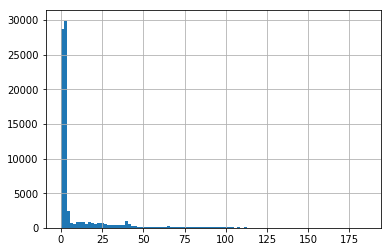

In [88]:
#Let's plot a histogram of the discrepancies in the distances.
#Omit the 10km bad data point at the end, and plot the last column of the dataframe (dist_difference).
#Great, so it looks like the vast majority of the distance calculations are quite similar
d_northbound_locations_sorted.iloc[:-1, -1].hist(bins=100)

## Plot a histogram of the distance to the closest stop

(omitting the "bad" data point at the end of the sorted dataframe)

x-axis = meters to closest stop

y-axis = number of bus locations at a given distance to the closest stop

Nearly half of the locations are very close to the nearest stop, but there are a significant number that are up to several hundered meters away.

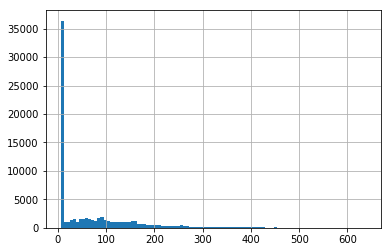

In [89]:
#Now let's plot a histogram of the actual distances from the stops.
#Omit the 10km bad data point at the end, and plot the 3rd to last column of the dataframe (meters_to_stop).
d_northbound_locations_sorted.iloc[:-1, -3].hist(bins=100)

In [90]:
#So about half of the distances are very close to the stop (~37,000 out of ~77,000), 
#but there are a significant number that are several hundered meters away.
d_northbound_locations_sorted.shape

(77723, 11)

## What does the distribution look like if we omit the smallest values (<= 10m)?

x-axis = meters to closest stop

y-axis = number of bus locations at a given distance to the closest stop

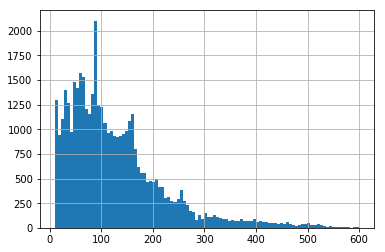

In [102]:
#What does the distribution look like if we omit the smallest values (<= 10m)?
d_northbound_locations_sorted.loc[
    (10 < d_northbound_locations_sorted.meters_to_stop)
    & (d_northbound_locations_sorted.meters_to_stop < 600),
    'meters_to_stop'
].hist(bins=100)

### Same plot, but for the Euclidean approximations:

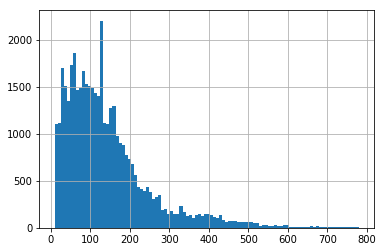

In [101]:
#What does the distribution for the Euclidean approximation look like if we omit the smallest values (<= 10m)?
#It looks like roughly a monotonic transformation.
d_northbound_locations_sorted.loc[
    (10 < d_northbound_locations_sorted.meters_to_stop)
    & (d_northbound_locations_sorted.meters_to_stop < 800),
    'euclid_meters_to_stop'
].hist(bins=100)

## What if we plot the great circle distance vs. the Euclidean approximation?

Nice! The graph indicates that there's clearly a mathematical relationship between them, which is what we expect. My guess is that the different "lines" correspond to different orientations of the bus. E.g all the points along a line of fixed slope correspond to bus locations along one straight stretch of road, and the slope depends on how much the road deviates from a perfectly north-south orientation.  

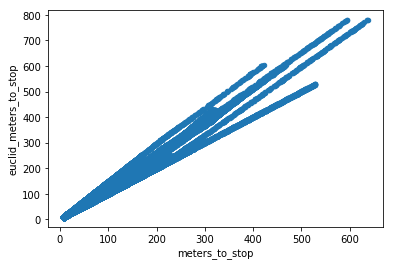

In [107]:
#Ok, so there's clearly a mathematical relationship between the great circle distance and the Euclidean approximation.
#Probably each line corresponds to a specific lattitude and/or longitude.
d_northbound_locations_sorted.iloc[:-1].plot.scatter(x='meters_to_stop', y='euclid_meters_to_stop')

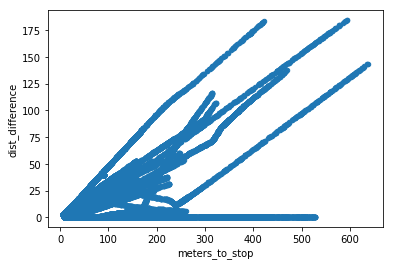

In [108]:
#This should be basically the above graph with the y-values shifted down by the x-values,
#except the absolute values might mess it up a bit.
d_northbound_locations_sorted.iloc[:-1].plot.scatter(x='meters_to_stop', y='dist_difference')

## Save the D locations in HDF5 format

Save the raw lattitude and longitude rather than the Point object to avoid pickling, which raises a warning (see the original code for the E Line below). It will be easy to convert back to Points when we load the data.

In [112]:
#Display the data we want to save
d_northbound_locations[['route_id', 'trip_id', 'vehicle_id',
                        'vehicle_lat', 'vehicle_long', 
                        'closest_stop_id', 'meters_to_stop']].head()

,route_id,trip_id,vehicle_id,vehicle_lat,vehicle_long,closest_stop_id,meters_to_stop
timestamp_utc,,,,,,,
2017-12-31 23:58:45,102581,34921896,6093,47.649120,-122.376137,14170,7.332701
2017-12-31 23:59:07,102581,34921897,6203,47.620068,-122.355438,2332,6.837902
2017-12-31 23:59:45,102581,34921897,6203,47.620094,-122.355438,2332,7.454585
2018-01-01 00:00:25,102581,34921896,6093,47.659508,-122.376221,14200,437.283047
2018-01-01 00:01:06,102581,34921897,6203,47.623188,-122.355415,2360,7.445441


In [113]:
#Save the data to a .h5 file
d_northbound_locations[['route_id', 'trip_id', 'vehicle_id',
                        'vehicle_lat', 'vehicle_long', 
                        'closest_stop_id', 'meters_to_stop']
                      ].to_hdf(
    './data/intermed/d_northbound_locations_2018-01.h5', key='d_northbound_locations_df', mode='w')

In [48]:
# e_northbound_locations.index.names = ['timestamp_utc']
# e_northbound_locations.head()

,route_id,trip_id,vehicle_id,coordinates,closest_stop_id
timestamp_utc,,,,,
2017-12-31 23:58:46,102615,34922164,6211,POINT (-122.3445739746094 47.69481658935547),7750
2017-12-31 23:59:04,102615,34922180,6088,POINT (-122.3435592651367 47.61811828613281),6235
2017-12-31 23:59:05,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103
2017-12-31 23:59:22,102615,34922163,6062,POINT (-122.3457260131836 47.75570297241211),75881
2018-01-01 00:00:08,102615,34922131,6054,POINT (-122.3424072265625 47.77417755126953),16103


In [49]:
# e_northbound_locations.to_hdf('./data/intermed/e_northbound_locations_2018-01.h5', key='e_northbound_locations_gdf', mode='w')

/Users/aps/miniconda3/envs/realtime_buses/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['coordinates']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
